## Importing Packages for the model

In [ ]:
import datetime
import numpy as np
import pandas as pd
from scipy.io import loadmat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.mode.chained_assignment = None  # default='warn'


import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

## List of Functions

1. Loading data - load_data
2. Extracting Data - extracting_data
3. Charging Battery Graphs plotting - charging_battry_graphs
4. Discharging Battery Graphs plotting - discharging_battry_graphs
5. Plotting SOH grahp - plot_soh

# File Location

In [ ]:
# example battery location
#data05 = loadmat(r"/content/drive/MyDrive/5. Battery Data Set/1. BatteryAgingARC-FY08Q4/B0018.mat")

#total number of batteries under consideration - B0018,B005,B006,B007
from google.colab import drive
drive.mount('/content/drive')
# location of the drive
file_location = "/content/drive/MyDrive/5. Battery Data Set/1. BatteryAgingARC-FY08Q4/"

Mounted at /content/drive


## Function to load data

In [ ]:
def load_data(battery):

  '''
  """
     This function takes the .mat file and give out a list of dataframes that has
      the Charging cycle data, Discharging cycle data and the Capacity data for each cycle.


    Input :
    --------------
      1 .mat file containing the cycling data  for each battery

    Return :
    --------------
    a list of Dataframes [Charging , Discharging, Capacity ]
    Columns in Chargning - ['cycle', 'ambient_temperature', 'datetime',
                        'voltage_measured', 'current_measured',
                        'temperature_measured', 'current_charger',
                        'voltage_charger', 'time']
    Columns in Discharging - ['cycle', 'ambient_temperature', 'datetime',
                                'capacity', 'voltage_measured',
                                'current_measured', 'temperature_measured',
                                'current_load', 'voltage_load', 'time']
    Columns in Capacity - ['cycle', 'ambient_temperature', 'datetime',
                                'capacity']
    """

  '''
  mat = loadmat(file_location + battery + '.mat')
  print('Total data in dataset: ', len(mat[battery][0, 0]['cycle'][0]))
  #mat = data05

  counter = 0

  charge_data = []
  discharge_data = []
  capacity_data = []

  for i in range(len(mat[battery][0, 0]['cycle'][0])):
    row = mat[battery][0, 0]['cycle'][0, i]


 # Charging
    if row['type'][0] == 'charge':
      ambient_temperature = row['ambient_temperature'][0][0]

      date_time = datetime.datetime(int(row['time'][0][0]),
                               int(row['time'][0][1]),
                               int(row['time'][0][2]),
                               int(row['time'][0][3]),
                               int(row['time'][0][4])) + datetime.timedelta(seconds=int(row['time'][0][5]))

      data = row['data']


      for j in range(len(data[0][0]['Voltage_measured'][0])):
        voltage_measured = data[0][0]['Voltage_measured'][0][j]
        current_measured = data[0][0]['Current_measured'][0][j]
        temperature_measured = data[0][0]['Temperature_measured'][0][j]
        current_charger = data[0][0]['Current_charge'][0][j]
        voltage_charger = data[0][0]['Voltage_charge'][0][j]
        time = data[0][0]['Time'][0][j]


        charge_data.append([counter + 1, ambient_temperature, date_time,
                        voltage_measured, current_measured,
                        temperature_measured, current_charger,
                        voltage_charger, time])

    if row['type'][0] == 'discharge':

      ambient_temperature = row['ambient_temperature'][0][0]

      date_time = datetime.datetime(int(row['time'][0][0]),
                               int(row['time'][0][1]),
                               int(row['time'][0][2]),
                               int(row['time'][0][3]),
                               int(row['time'][0][4])) + datetime.timedelta(seconds=int(row['time'][0][5]))

      data = row['data']

      capacity = data[0][0]['Capacity'][0][0]

      for j in range(len(data[0][0]['Voltage_measured'][0])):
        voltage_measured = data[0][0]['Voltage_measured'][0][j]
        current_measured = data[0][0]['Current_measured'][0][j]
        temperature_measured = data[0][0]['Temperature_measured'][0][j]
        current_load = data[0][0]['Current_load'][0][j]
        voltage_load = data[0][0]['Voltage_load'][0][j]
        time = data[0][0]['Time'][0][j]


        discharge_data.append([counter + 1, ambient_temperature, date_time, capacity,
                        voltage_measured, current_measured,
                        temperature_measured, current_load,
                        voltage_load, time])

      capacity_data.append([counter + 1, ambient_temperature, date_time, capacity])

      counter = counter + 1


  return [pd.DataFrame(data=charge_data,columns=['cycle', 'ambient_temperature', 'datetime',
                        'voltage_measured', 'current_measured',
                        'temperature_measured', 'current_charger',
                        'voltage_charger', 'time']),pd.DataFrame(data=discharge_data,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity', 'voltage_measured',
                                'current_measured', 'temperature_measured',
                                'current_load', 'voltage_load', 'time']),
          pd.DataFrame(data=capacity_data,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity'])]

Battery_data = load_data('B0005')

#charge , discharge, capacity = Battery_data
#charge['cycle'].nunique()

Total data in dataset:  616


## Features of the battery while charging

In [ ]:
def charging_battery_graphs(extracted_battery):

  """
  This function plots the graphs of
  1. Charging Current vs time
  2. Charging Voltage vs time
  3. Temperature of battery vs time
  of the battery while charging

  The plots are for 4 different percentages of the battery

  Input :
  ---------------------------
  Takes a list of Dataframes . This is equal to the return type of load_data() function.


  Return :
  ------------------
  Null type.
  The function plots the graphs of the charging profile of the battery
  """

  charge , b , c = extracted_battery
  C = c['capacity'].max()

  for i in [0.99,0.95,0.90,0.85,0.80,0.75,0.70]:
    cyc = c.loc[(c['capacity']/C - i).abs().idxmin()]['cycle']
    plot_df = charge.loc[(charge['cycle'] == cyc ), ['current_measured','time']]
    plt.plot(plot_df['time'], plot_df['current_measured'])

  plt.legend(['100%' , '90%', '80%' ,'70%'])
  plt.ylabel('Charging Current(A)')
  plt.xlabel('Time(s)')
  plt.title('Charging Current vs Time Graph')
  plt.ylim(-1,2)
  sns.set_style("darkgrid")
  plt.show()



  for i in [0.99,0.95,0.90,0.85,0.80,0.75,0.70]:
    cyc = c.loc[(c['capacity']/C - i).abs().idxmin()]['cycle']
    plot_df = charge.loc[(charge['cycle'] == cyc ), ['voltage_measured','time']]
    plt.plot(plot_df['time'], plot_df['voltage_measured'])

  plt.legend(['100%' , '90%', '80%' ,'70%'])
  plt.ylabel('Charging Voltage(V)')
  plt.xlabel('Time(s)')
  plt.ylim(3.8,4.3)
  plt.title('Charging Voltage vs Time Graph')
  sns.set_style("darkgrid")
  plt.show()

  for i in [0.99,0.95,0.90,0.85,0.80,0.75,0.70]:
    cyc = c.loc[(c['capacity']/C - i).abs().idxmin()]['cycle']
    plot_df = charge.loc[(charge['cycle'] == cyc ), ['temperature_measured','time']]
    plt.plot(plot_df['time'], plot_df['temperature_measured'])

  plt.legend(['0.99%','0.95%','0.90%','0.85%','0.80%','0.75%','0.70%'])
  plt.ylabel('Temperature of Battery')
  plt.xlabel('Time(s)')
  plt.title('Temperature vs Time Graph')
  sns.set_style("darkgrid")
  plt.show()

  plt.show()

## Graphs for the battery B0005 while charging



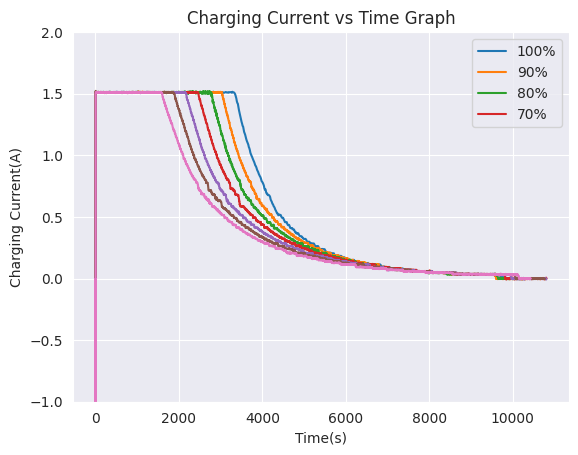

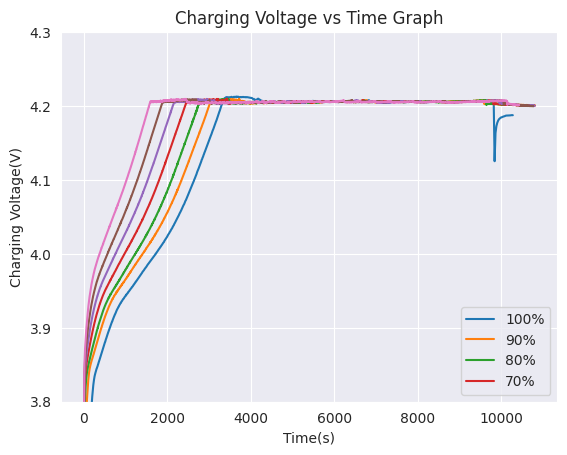

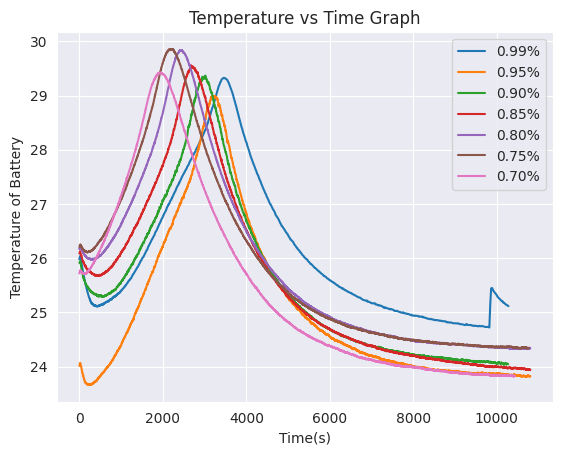

In [ ]:
charging_battery_graphs(Battery_data)

In [ ]:
def discharging_battery_graphs(extracted_battery):

  """
  This function plots the graphs of
  1. Discharging Current vs time
  2. Discharging Voltage vs time
  3. Temperature of battery vs time
  of the battery while Discharging

  The plots are for 4 different cycles

  Input :
  ---------------------------
  Takes a list of Dataframes . This is equal to the return type of load_data() function.


  Return :
  ------------------
  Null type.
  The function plots the graphs of the discharging profile of the battery

  """

  a,discharge,c = extracted_battery
  C = c['capacity'].max()

  for i in [0.99,0.90,0.80,0.70]:
    cyc = c.loc[(c['capacity']/C - i).abs().idxmin()]['cycle']
    plot_df = discharge.loc[(discharge['cycle'] == cyc ), ['current_measured','time']]
    plt.plot(plot_df['time'], plot_df['current_measured'])

  plt.legend(['100%' , '90%', '80%' ,'70%'])
  plt.ylabel('Charging Current')
  plt.xlabel('Time')
  plt.title('Discharging Current vs Time Graph at the load')
  sns.set_style("darkgrid")
  plt.show()

  for i in [0.99,0.90,0.80,0.70]:
    cyc = c.loc[(c['capacity']/C - i).abs().idxmin()]['cycle']
    plot_df = discharge.loc[(discharge['cycle'] == cyc), ['voltage_measured','time']]
    plt.plot(plot_df['time'], plot_df['voltage_measured'])

  plt.legend(['100%' , '90%', '80%' ,'70%'])
  plt.ylabel('Charging Voltage')
  plt.xlabel('Time')
  plt.title('Dischaging Voltage vs Time Graph at the load ')
  sns.set_style("darkgrid")

  plt.show()

  for i in [0.99,0.90,0.80,0.70]:
    cyc = c.loc[(c['capacity']/C - i).abs().idxmin()]['cycle']
    plot_df = discharge.loc[(discharge['cycle'] == cyc ), ['temperature_measured','time']]
    plt.plot(plot_df['time'], plot_df['temperature_measured'])


  plt.legend(['100%' , '90%', '80%' ,'70%'])
  plt.ylabel('Discharging Current')
  plt.xlabel('Time')
  plt.title('Discharging Current vs Time Graph at the load ')
  sns.set_style("darkgrid")
  plt.show()

## Graphs of Battery B0005 while discharging

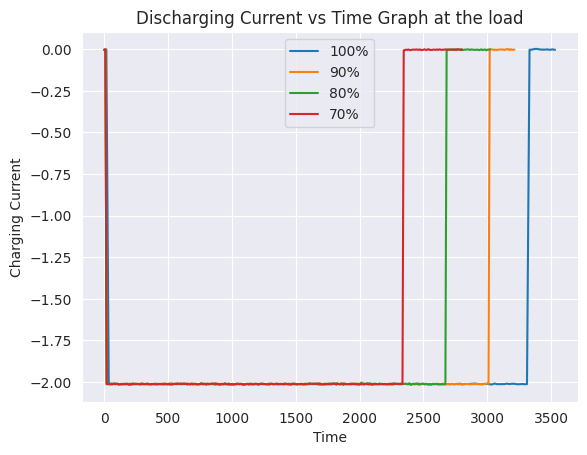

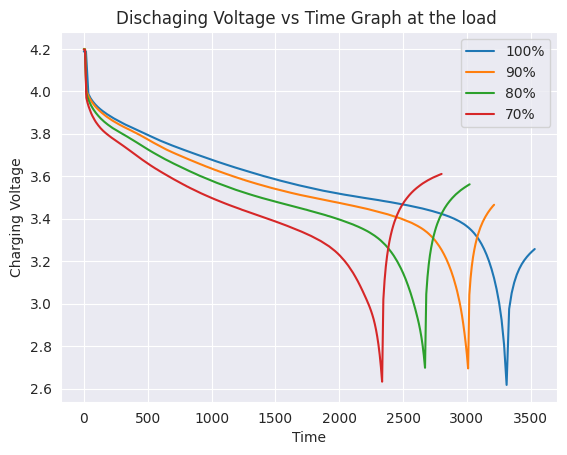

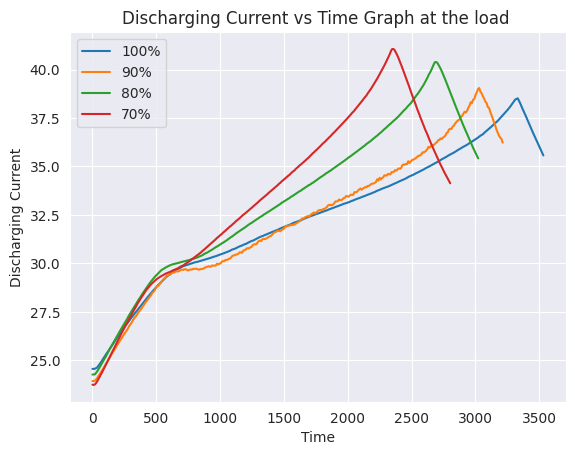

In [ ]:
discharging_battery_graphs(Battery_data)

In [ ]:
def plot_soh(extracted_battery):

  a,b,capacity = extracted_battery
  plot_df = capacity.loc[(capacity['cycle']>=1),['cycle','capacity']]
  sns.set_style("darkgrid")
  plt.figure(figsize=(12, 8))
  plt.plot(plot_df['cycle'], plot_df['capacity'])


  #Draw threshold
  plt.plot([0.,len(capacity)], [1.4, 1.4])
  plt.ylabel('Capacity')

  # make x-axis ticks legible
  adf = plt.gca().get_xaxis().get_major_formatter()
  plt.xlabel('cycle')
  plt.title('Discharge of Battery')

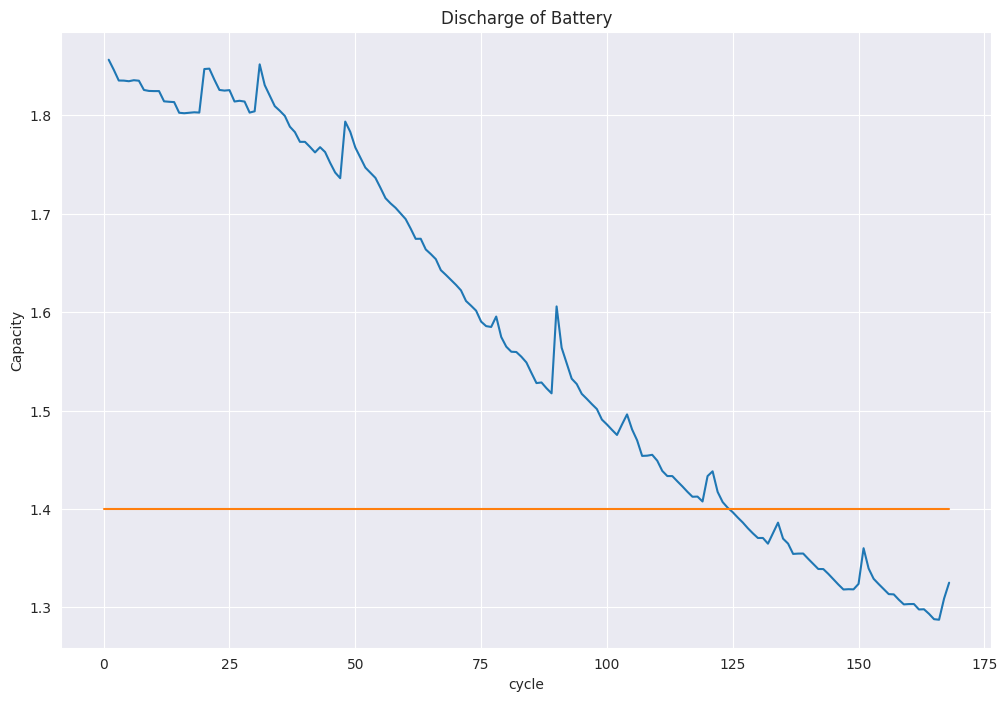

In [ ]:
plot_soh(Battery_data)

# CNN Model for SOH estimations

### Function to extract featurs

In [ ]:
def extracting_features(extracted_battery):

  '''
  This function is used to extract the data from the charging cycle of each battery and then input
  it a format that is convinent for us. Please refer to the documentation for more details

  Input :
  ------------------------
  The outout of the load_data function

  Return :
  ------------------------
  For each charging cycle the attributes are taken at evenly spaced SOC steps and are returned as One array.
  We have one row of data for each cycle. It captures the data from the entire charging step of the cycle.
  '''
  charge,discharge,capacity = extracted_battery

  attributes_charge = ['voltage_measured','current_measured', 'temperature_measured', 'current_charger',
         'voltage_charger', 'time', 'cumulative_charge']


  for j in range(1,capacity['cycle'].nunique()):

    charge1 = charge[charge['cycle'] == j]
    charge1['dt'] = (charge1['time'] - charge1['time'].shift(1)) / 3600
    charge1['amt_charged_at_dt'] = charge1['dt']*charge1['current_charger']
    charge1['cumulative_charge'] =  charge1['amt_charged_at_dt'].cumsum()
    charge1['cumulative_charge'] = charge1['cumulative_charge']/charge1['cumulative_charge'].max()


    if charge1.empty :
      if j == 1 :
        final_dataset = long_arr
      else:
        final_dataset = np.vstack((final_dataset,long_arr))

    else :
      long_arr = np.array([])

      for i in range(0,20):

        temp_array = np.array([])

        target_value = (charge1['cumulative_charge'].max() / 20 ) * i
        closest_row_charge = charge1.loc[(charge1['cumulative_charge'] - target_value).abs().idxmin()][attributes_charge].values

        temp_array = closest_row_charge

        long_arr = np.concatenate((long_arr , temp_array))

      if j == 1 :
        final_dataset = long_arr
      else: final_dataset = np.vstack((final_dataset,long_arr))

  return(final_dataset)

In [ ]:
# All Battery Data
B0005, B0006, B0007, B0018 = load_data('B0005') , load_data('B0006') , load_data('B0007') ,load_data('B0018')

Total data in dataset:  616
Total data in dataset:  616
Total data in dataset:  616
Total data in dataset:  319


## An example fo the model I have considered is given below
I have used 3 battery data as the training set and the remaing battery data is used as the testing set. We can see that the loss function decreeses wit each epoch and the model does a very good job of fitting the data.

In [ ]:
B0005_f = extracting_features(B0005)
B0006_f = extracting_features(B0006)
B0018_f = extracting_features(B0018)
final_dataset = np.concatenate((B0005_f,B0006_f))
final_dataset = np.concatenate((final_dataset,B0018_f))

### Feature Scaling

In [ ]:
sc = MinMaxScaler(feature_range=(0,1))
train_dataset = sc.fit_transform(final_dataset)

###Defining the CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=20, kernel_size=3, activation='relu', input_shape=(final_dataset.shape[1], 1)),
    tf.keras.layers.MaxPooling1D(pool_size=2, strides=2),
    tf.keras.layers.Conv1D(filters=40, kernel_size=4, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2, strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=40, activation='relu'),
    tf.keras.layers.Dropout(0.2),  # Dropout layer with dropout rate of 20%
    tf.keras.layers.Dense(units=1)
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 138, 20)           80        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 69, 20)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 66, 40)            3240      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 33, 40)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 1320)              0         
                                                                 
 dense (Dense)               (None, 40)                5

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# Getting the Y values for Training set
soh= []
for i in [B0005,B0006, B0018]:
  a,b,capacity = i
  C = capacity['capacity'].max()
  for i in range(1,len(capacity)):
    soh.append([capacity['capacity'][i] / C])
soh = pd.DataFrame(data=soh, columns=['SoH'])

In [ ]:
sc = MinMaxScaler(feature_range=(0,1))
train_dataset = sc.fit_transform(final_dataset)

model.compile(optimizer=Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08), loss='mean_absolute_error')

model.fit(x=train_dataset, y=soh.to_numpy(), batch_size=25, epochs=50)

Epoch 1/50
19/19 [==============================] - 13s 23ms/step - loss: 0.2455
Epoch 2/50
19/19 [==============================] - 0s 10ms/step - loss: 0.1133
Epoch 3/50
19/19 [==============================] - 0s 7ms/step - loss: 0.0954
Epoch 4/50
19/19 [==============================] - 0s 8ms/step - loss: 0.0948
Epoch 5/50
19/19 [==============================] - 0s 9ms/step - loss: 0.0950
Epoch 6/50
19/19 [==============================] - 0s 7ms/step - loss: 0.0898
Epoch 7/50
19/19 [==============================] - 0s 14ms/step - loss: 0.0869
Epoch 8/50
19/19 [==============================] - 0s 11ms/step - loss: 0.0867
Epoch 9/50
19/19 [==============================] - 0s 7ms/step - loss: 0.0945
Epoch 10/50
19/19 [==============================] - 0s 7ms/step - loss: 0.0944
Epoch 11/50
19/19 [==============================] - 0s 7ms/step - loss: 0.0898
Epoch 12/50
19/19 [==============================] - 0s 7ms/step - loss: 0.0926
Epoch 13/50
19/19 [=========================

### I have used Batteries B0005, B0006, B0018 for building the model
I have used Battery B0007 as my test set.

In [ ]:
B0007_f = extracting_features(B0007)
test_dataset = sc.fit_transform(B0007_f)
soh_pred = model.predict(test_dataset)

6/6 [==============================] - 0s 15ms/step


In [ ]:
# extracting actual values of train_y
soh= []
a,b,capacity = B0007
C = capacity['capacity'].max()
for i in range(1,len(capacity)):
  soh.append([capacity['capacity'][i] / C])
soh = pd.DataFrame(data=soh, columns=['SoH'])

Text(0.5, 1.0, 'Discharge B0007')

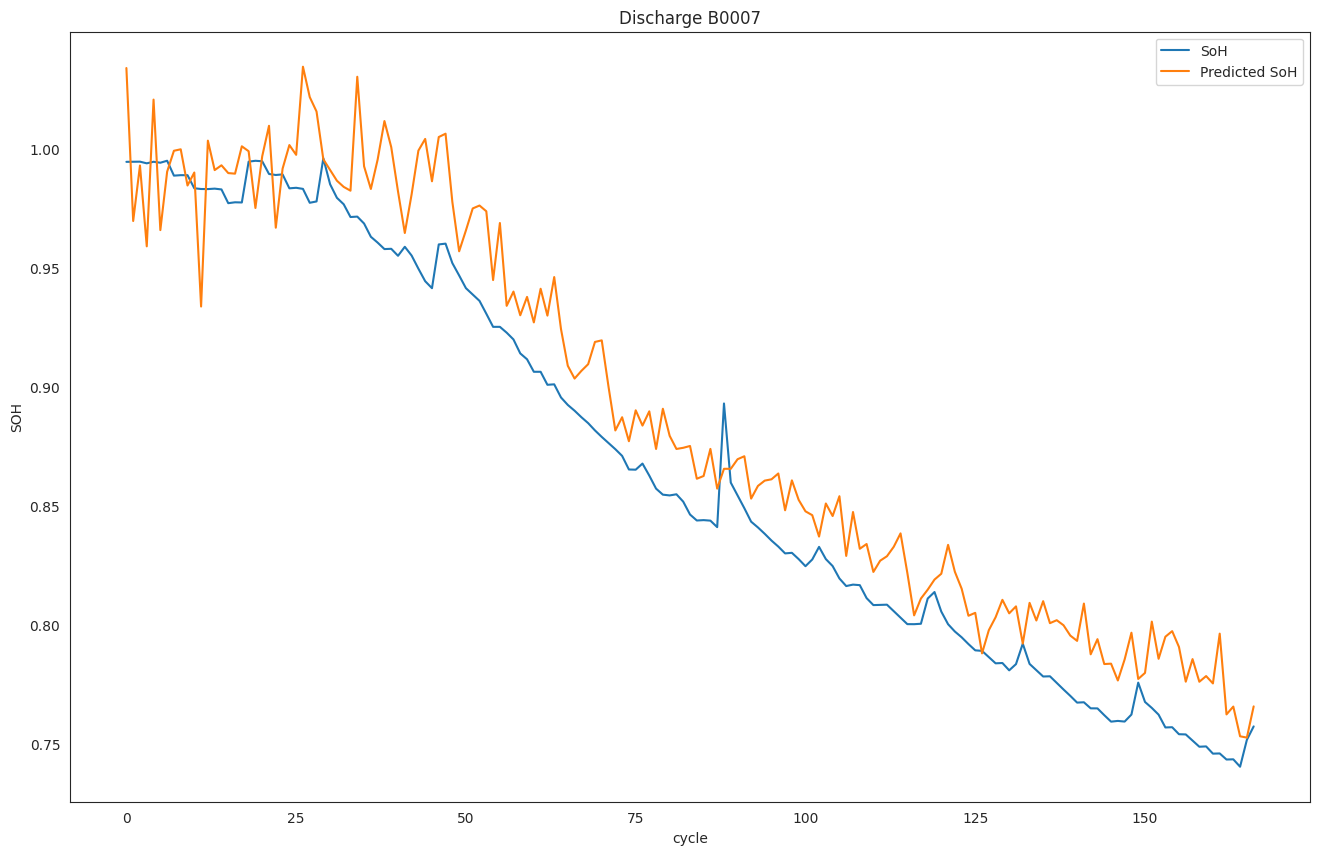

In [ ]:
sns.set_style("white")
plt.figure(figsize=(16, 10))

plt.plot(soh.index, soh.values, label='SoH')
plt.plot(soh.index, soh_pred, label='Predicted SoH')

#Draw threshold
#plt.plot([0.,len(capacity)], [0.70, 0.70], label='Threshold')
plt.ylabel('SOH')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.legend()
plt.title('Discharge B0007')

In [ ]:
def calculate_errors(y_true, y_pred):
    """
    Calculate Mean Squared Error (MSE) and Mean Absolute Error (MAE) between two arrays.

    Args:
        y_true (ndarray): The true values.
        y_pred (ndarray): The predicted values.

    Returns:
        mse (float): Mean Squared Error.
        mae (float): Mean Absolute Error.
    """
    # Calculate MSE
    mse = np.mean((y_true - y_pred) ** 2)

    # Calculate MAE
    mae = np.mean(np.abs(y_true - y_pred))
    # Print the results
    print("MSE for Battery B0007 :", mse)
    print("MAE for Battery B0007:", mae)
    return mse, mae
x,y = calculate_errors(soh.values,soh_pred)

MSE for Battery B0007 : 0.0006854214505986698
MAE for Battery B0007: 0.022923128995719487


# LSTM Model for Prediction the RUL of a Battery

In [ ]:

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
 X, y = list(), list()
 for i in range(len(sequence)):
 # find the end of this pattern
  end_ix = i + n_steps
 # check if we are beyond the sequence
  if end_ix > len(sequence)-1:
    break
 # gather input and output parts of the pattern
  seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
  X.append(seq_x)
  y.append(seq_y)
 return np.array(X), np.array(y)

In [ ]:
def first_below_threshold(arr, threshold):
    for index, element in enumerate(arr):
        if element < threshold:
            return index
    return -1

I have 4 different functions that are used to determine the RUL of a bettery using LSTM model.

For each battery I have used 2 other batteries to train the model and the remianing battery as the validation data.

Example - For battery B0005 I used B0006 and B00018 for training and B0007 as validation dataset

I have only one of the functions printed here. The RUL of the Batteries were estimated for each battery for 5 times and I have recorded the values.

## EOL OF Batteries
###B0006 - 92
###B0007 - 167  
###B0005 - 134  
###B0018 - 124

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanAbsoluteError

Epoch 1/300
6/6 [==============================] - 12s 632ms/step - loss: 0.2234 - val_loss: 0.2099
Epoch 2/300
6/6 [==============================] - 0s 31ms/step - loss: 0.1239 - val_loss: 0.0357
Epoch 3/300
6/6 [==============================] - 0s 29ms/step - loss: 0.0718 - val_loss: 0.1664
Epoch 4/300
6/6 [==============================] - 0s 30ms/step - loss: 0.0834 - val_loss: 0.1327
Epoch 5/300
6/6 [==============================] - 0s 26ms/step - loss: 0.0736 - val_loss: 0.0600
Epoch 6/300
6/6 [==============================] - 0s 27ms/step - loss: 0.0648 - val_loss: 0.0507
Epoch 7/300
6/6 [==============================] - 0s 26ms/step - loss: 0.0659 - val_loss: 0.1113
Epoch 8/300
6/6 [==============================] - 0s 27ms/step - loss: 0.0601 - val_loss: 0.0282
Epoch 9/300
6/6 [==============================] - 0s 28ms/step - loss: 0.0516 - val_loss: 0.0273
Epoch 10/300
6/6 [==============================] - 0s 27ms/step - loss: 0.0616 - val_loss: 0.0945
Epoch 11/300
6/6 

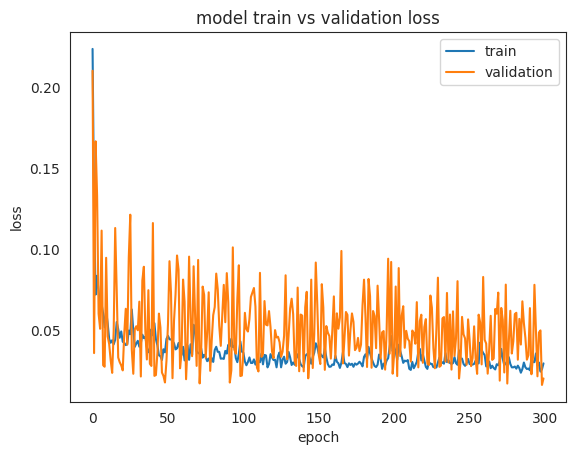

1/1 [==============================] - 0s 31ms/step
Cycle predicted to reach RUL : 54
actual cycle  to reach RUL : 100
Predicted cycle for reaching EOL  = 
Actual cycle for reaching EOL  = 


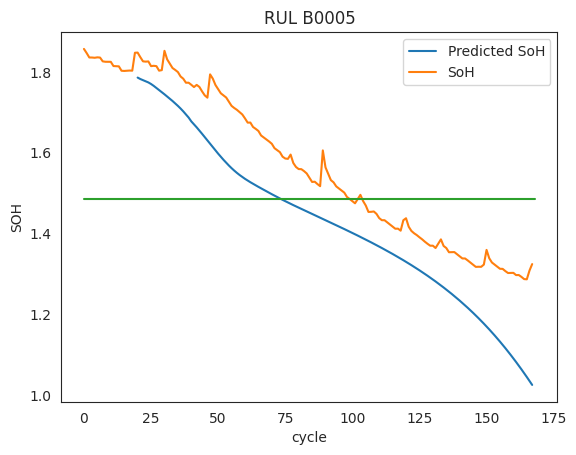

In [ ]:
def lstm_B005(size):
  '''

  This is one function to determine the LSTM of a single battery B0005.
  I used similar functions to determine the RUL of other batteries as well.

  '''

  #getting training data
  a1,b1,c1 = B0006
  a2,b2,c2 = B0018
  chunk_size =size
  #X_train = np.reshape(np.array(c1.capacity.append(c2.capacity)),(-1,1))
  X_train = np.reshape(np.array(c1.capacity),(-1,1))
  from sklearn.preprocessing import MinMaxScaler
  scaling = MinMaxScaler()
  scaling.fit(X_train)
  X_train = scaling.transform(X_train)
  X_train , Y_train = split_sequence(X_train,size)

  # getting validation values
  a1,b1,c1 = B0007
  chunk_size =size
  X_val = np.reshape(np.array(c1.capacity),(-1,1))
  X_val = scaling.transform(X_val)
  X_val,Y_val = split_sequence(X_val,size)

  model = Sequential()
  model.add(LSTM(400, return_sequences=True, input_shape=(X_train.shape[1], 1)))
  model.add(Dropout(0.2))
  model.add(LSTM(50, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(200, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(50, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(200, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(100, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(32))
  model.add(Dense(1))

  # Compile the model
  loss_function = MeanAbsoluteError()
  optimizer = Adam(learning_rate= 0.001)
  model.compile(loss=loss_function, optimizer=optimizer)

  # Train the model
  B0005_history  = model.fit(X_train, Y_train, epochs=300, batch_size=25, verbose=1, validation_data=(X_val, Y_val))

  plt.plot(B0005_history.history['loss'])
  plt.plot(B0005_history.history['val_loss'])
  plt.title('model train vs validation loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper right')
  plt.show()

  a1,b1,c1 = B0005
  chunk_size = size
  pred_len = len(c1)
  X_test = np.reshape(np.array(c1.capacity),(-1,1))
  X_test = scaling.transform(X_test)
  X_test,Y_test = split_sequence(X_test,size)
  X_test = X_test[0].reshape((1,size,1))


  #making_predictions
  test_predictions = []
  #first_eval_batch = scaled_train[-n_input:]
  #current_batch = first_eval_batch.reshape((1, n_input, n_features))

  for i in range(size,pred_len):

      # get the prediction value for the first batch
    current_pred = model.predict(X_test)[0]

      # append the prediction into the array
    test_predictions.append(current_pred)

      # use the prediction to update the batch and remove the first value
    X_test = np.append(X_test[:,1:,:],[[current_pred]],axis=1)


  cycle_pred = first_below_threshold(scaling.inverse_transform(test_predictions), c1.capacity.max() * 0.80)
  actual_cycle = first_below_threshold(c1.capacity,c1.capacity.max() * 0.80)

  print('Cycle predicted to reach RUL :' , cycle_pred )
  print('actual cycle  to reach RUL :' , actual_cycle )

  plt.plot(range(size,pred_len) , scaling.inverse_transform(test_predictions))
  plt.plot(range(len(c1.capacity)),c1.capacity)

#Draw threshold
  plt.plot([0.,len(c1)], [c1.capacity.max() * 0.80, c1.capacity.max() * 0.80], label='Threshold')
  plt.ylabel('SOH')
  # make x-axis ticks legible
  plt.xlabel('cycle')
  plt.legend(['Predicted SoH','SoH'])
  plt.title('RUL B0005')

  print("Predicted cycle for reaching EOL  = " , )
  print("Actual cycle for reaching EOL  = " , )

  return(test_predictions)
B0005_history = lstm_B005(20)

Epoch 1/300
11/11 [==============================] - 12s 233ms/step - loss: 0.2801 - val_loss: 0.1252
Epoch 2/300
11/11 [==============================] - 0s 24ms/step - loss: 0.1787 - val_loss: 0.0724
Epoch 3/300
11/11 [==============================] - 0s 20ms/step - loss: 0.1158 - val_loss: 0.0403
Epoch 4/300
11/11 [==============================] - 0s 20ms/step - loss: 0.1002 - val_loss: 0.0511
Epoch 5/300
11/11 [==============================] - 0s 20ms/step - loss: 0.1166 - val_loss: 0.0395
Epoch 6/300
11/11 [==============================] - 0s 20ms/step - loss: 0.1091 - val_loss: 0.0430
Epoch 7/300
11/11 [==============================] - 0s 20ms/step - loss: 0.0948 - val_loss: 0.0543
Epoch 8/300
11/11 [==============================] - 0s 20ms/step - loss: 0.0970 - val_loss: 0.1345
Epoch 9/300
11/11 [==============================] - 0s 20ms/step - loss: 0.1217 - val_loss: 0.0417
Epoch 10/300
11/11 [==============================] - 0s 20ms/step - loss: 0.1038 - val_loss: 0.09

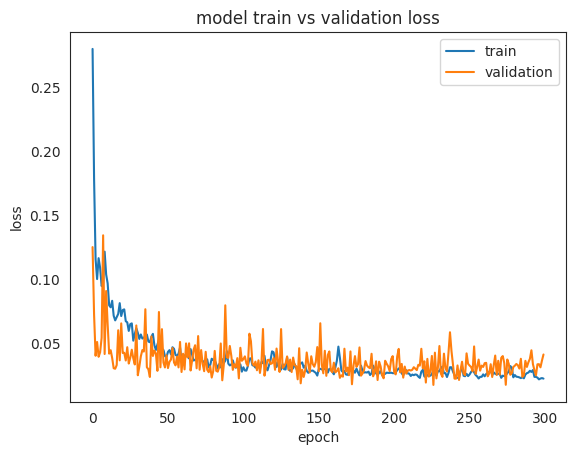

1/1 [==============================] - 0s 23ms/step
(143, 1) to add to cycle_pred
(168,) to add to actual_cycle
Cycle predicted to reach RUL : 40
actual cycle  to reach RUL : 69


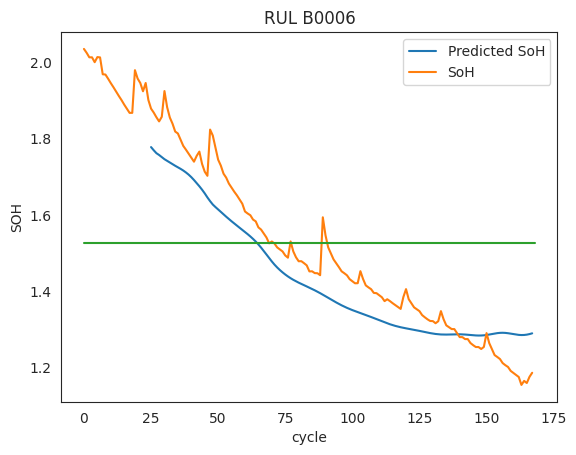

In [ ]:
def lstm_B006(size):
  '''

  This is one function to determine the LSTM of a single battery B0005.
  I used similar functions to determine the RUL of other batteries as well.

  '''

  #getting training data
  a1,b1,c1 = B0005
  a2,b2,c2 = B0018
  chunk_size =size
  X_train = np.reshape(np.array(c1.capacity.append(c2.capacity)),(-1,1))
  #X_train = np.reshape(np.array(c1.capacity),(-1,1))
  from sklearn.preprocessing import MinMaxScaler
  scaling = MinMaxScaler()
  scaling.fit(X_train)
  X_train = scaling.transform(X_train)
  X_train , Y_train = split_sequence(X_train,size)

  # getting validation values
  a1,b1,c1 = B0007
  chunk_size =size
  X_val = np.reshape(np.array(c1.capacity),(-1,1))
  X_val = scaling.transform(X_val)
  X_val,Y_val = split_sequence(X_val,size)

  model = Sequential()
  model.add(LSTM(400, return_sequences=True, input_shape=(X_train.shape[1], 1)))
  model.add(Dropout(0.2))
  model.add(LSTM(50, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(200, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(50, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(200, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(100, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(32))
  model.add(Dense(1))

  # Compile the model
  loss_function = MeanAbsoluteError()
  optimizer = Adam(learning_rate= 0.001)
  model.compile(loss=loss_function, optimizer=optimizer)

  # Train the model
  B0006_history  = model.fit(X_train, Y_train, epochs=300, batch_size=25, verbose=1, validation_data=(X_val, Y_val))

  plt.plot(B0006_history.history['loss'])
  plt.plot(B0006_history.history['val_loss'])
  plt.title('model train vs validation loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper right')
  plt.show()

  a1,b1,c1 = B0006
  chunk_size = size
  pred_len = len(c1)
  X_test = np.reshape(np.array(c1.capacity),(-1,1))
  X_test = scaling.transform(X_test)
  X_test,Y_test = split_sequence(X_test,size)
  X_test = X_test[0].reshape((1,size,1))


  #making_predictions
  test_predictions = []
  #first_eval_batch = scaled_train[-n_input:]
  #current_batch = first_eval_batch.reshape((1, n_input, n_features))

  for i in range(size,pred_len):

      # get the prediction value for the first batch
    current_pred = model.predict(X_test)[0]

      # append the prediction into the array
    test_predictions.append(current_pred)

      # use the prediction to update the batch and remove the first value
    X_test = np.append(X_test[:,1:,:],[[current_pred]],axis=1)


  cycle_pred = first_below_threshold(scaling.inverse_transform(test_predictions), c1.capacity.max() * 0.75)
  actual_cycle = first_below_threshold(c1.capacity,c1.capacity.max() * 0.75)

  print(scaling.inverse_transform(test_predictions).shape , 'to add to cycle_pred')
  print(c1.capacity.shape , 'to add to actual_cycle')
  print('Cycle predicted to reach RUL :' , cycle_pred )
  print('actual cycle  to reach RUL :' , actual_cycle )

  plt.plot(range(size,pred_len) , scaling.inverse_transform(test_predictions))
  plt.plot(range(len(c1.capacity)),c1.capacity)

#Draw threshold
  plt.plot([0.,len(c1)], [c1.capacity.max() * 0.75, c1.capacity.max() * 0.75], label='Threshold')
  plt.ylabel('SOH')
  # make x-axis ticks legible
  plt.xlabel('cycle')
  plt.legend(['Predicted SoH','SoH'])
  plt.title('RUL B0006')

  return(B0006_history)
B0006_history = lstm_B006(25)